# Classification with MNIST
We'll be exploring a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. 

Each image is labeled with the digit it represents. 
Since we're trying to predict pictures; and said pictures possess labels, this will naturally fall as a classification problem. 

We will start by fetching the mnist_784 dataset from sklearn. Fortunately there's literally an import for just that, and then we will review the key fields of the dataset.

We will then take a look at it's overall shape.

In [1]:
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


'data' contains an array with one row per instance and one column per feature
'target' contains an array with labels. 

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

So, we have 70,000 images, with 784 features, as each image is 28 x 28 pixels, and each feature is one pixel's intensity from 0 to 255 (white to black)

In [4]:
y.shape

(70000,)

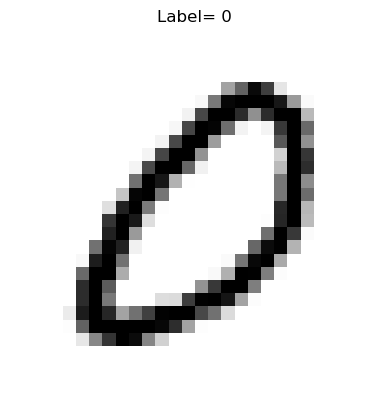

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

i=4389

some_digit = X[i]
some_digit_image = some_digit.reshape(28, 28)

zerosamples=[21,56,5665]

plt.imshow(some_digit_image, cmap="binary")
plt.title("Label= "+str(y[i]))
plt.axis("off")
plt.show()

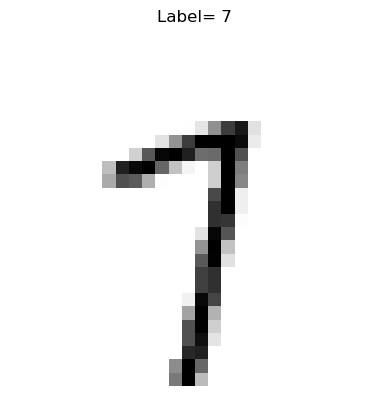

In [6]:
some_digit = X[42]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.title("Label= "+str(y[42]))
plt.show()

In [7]:
y[0]

'5'

In [8]:
def displayDigit(i, X):
    some_digit = X[i]
    some_digit_image = some_digit.reshape(28, 28)



    plt.imshow(some_digit_image, cmap="binary")
    plt.title("Label= "+str(y[i]))
    plt.axis("off")
    plt.show()

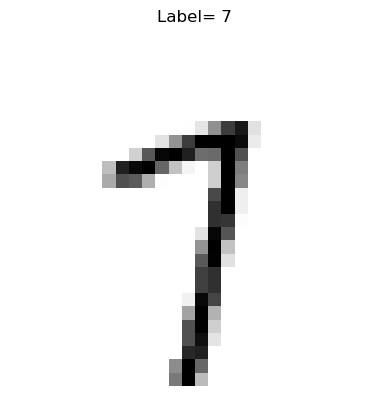

In [9]:
displayDigit(42, X)

Most ML algorithims expect numbers, so cast the labels as such. 

In [10]:
import numpy as np
y=y.astype(np.uint8)

Make sure you create a test set and set it aside before inspecting the data. 

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

For now, let's simplify the problem and try to simply classify the number 5, 1 and 7 seperately. While we're at it, let's time how long it takes to train them. 

In [12]:
import time
t5=time.time()
y_train_5 = (y_train == 5) ## true for all 5s, false for all other digits
y_test_5 = (y_test == 5)

print("Took: {0:2f} s to train how to recognize the number five (5).".format(time.time()-t5))

t1=time.time()
y_train_1 = (y_train == 1) ## true for all 1s, false for all other digits
y_test_1 = (y_test == 1)

print("Took: {0:2f} s to train how to recognize the number one (1).".format(time.time()-t1))

t7=time.time()
y_train_7 = (y_train == 7) ## true for all 7s, false for all other digits
y_test_7 = (y_test == 7)

print("Took: {0:2f} s to train how to recognize the number seven (7).".format(time.time()-t1))


Took: 0.000000 s to train how to recognize the number five (5).
Took: 0.000000 s to train how to recognize the number one (1).
Took: 0.000000 s to train how to recognize the number seven (7).


Now we pick a classifier and train it. Stochastic Gradient Descent (SGD) is one such classifier availiable in Scikit-learn.
It handles large data sets efficiently as it deals with training instances independently. 

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
some_digit = X[i]
sgd_clf.predict([some_digit])

array([ True])

In [15]:
sgd_clf.fit(X_train, y_train_1)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Time to check for the number 5. Is it in this set?

What about the number 1?

In [16]:
some_digit = X[42]
sgd_clf.predict([some_digit])

array([False])

What about the number 7?

In [17]:
sgd_clf.fit(X_train, y_train_7)
some_digit = X[42]
sgd_clf.predict([some_digit])

array([ True])

At a glance, look like our SGD classifier can predict the numbers 5, 1, and 7 without getting mixed up. How to measure this comes next.

# Performance Measures
Evaluating classifiers can be trickier than evaluating regressions seeing as this is unsuprivised learning.
Among the options include:

Cross-Validation

Confusion Matrix

Precision and Recall


## Cross-Validation

While we can utilize Scikit-Learn's cross-validation process, let's implement our own just for kicks and practice.

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

#here we're doing stratified sampling to keep things representative, doing it n times the amount of splits we want 
skfolds = StratifiedKFold(n_splits=4, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds= X_train[train_index]
    y_train_folds= y_train_5[train_index]
    X_test_fold= X_train[test_index]
    y_test_fold= y_train_5[test_index]
    
    #Time to fit the clone classifier and test how the number '5' will be predicted
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    #now compared the y-predictions with the test fold
    n_correct= sum(y_pred == y_test_fold)
    
    #let's make sure it's presented as a ratio
    print(n_correct / len(y_pred))

C:\Users\David\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9576666666666667
0.9664
0.9651333333333333
0.9536666666666667


### Using SkLearn's Cross Validator

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

Huh. Looks like we have over 95% accuracy, but considering we only need to compliment the probability of "not five" to make these predictions...meh.

Something is off that'll make us want to be more ***precise.*** We'll have to ***recall*** this later.

In [20]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

This is why accuracy isn't the best metric for classifiers, especially in dealing with skewed datasets (whereupon some classes are far more likely to occur than others).

## Confusion Matrix

The idea of a confusion matrix is to look at the number of times class A is counted as class B.   For example, how many times was the image of 5 confused for the number 3?

For that, you'd look at the 5th row in the 3rd column of the confusion matrix.

As such, to compute a confusion matrix, a set of *predictions* need to be compared to actual targets. In other words, you'll need to compare a test set to the actuals.

"cross_val_predict" within Sklearn eases that. 

1) From the training set for the number 5 earlier, create a prediction training set via cross_val_predict().
2) Form the confusion matrix via confusion_matrix(training, predictor) to studying the following matrix:

----

true negatives, false positives

false negatives, true positives

--                           --

In [22]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Above, each row represents an *actual class*, while each column represents a *predicted* class. 

---

true negatives (53892), false positives (687)

false negatives (1891), true positives (3530)

---

## Precision and Recall

sklearn.metrics contains libraries related to precision and recall. Recall the following formulas:

$precision = \frac{TP}{TP + FP}$


$recall = \frac{TP}{TP + FN}$

In [24]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

What this means is that, adjusting for False Positives, it's only properly identifying the image of 5 about 83% of the time. 

In [25]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

What this means is that, adjusting for False Negatives, it's only properly noting the image of 5 about 65% of the time, believing the rest 35% of the images of fives to not be the number five. 

We can combine the two aspects to create a final __F_Score__. It represents the *harmonic mean* between the two scores. That is, it gives more weight to lower values as opposed to a regular mean calculation.

Due to this, a high F-Score is high only if the precision and recall high.

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Precision and Recall have an inverse relationship. The more you increase one, the less you have of the other. 

As such, the F1_Score favors metrics with similiar precision and recall.

This may not be what you always want. For example, if you want a classifier that picks videos that are safe-for-children, you likely want more precision and less recall (i.e. risk falsely rejecting a good video and keeping safe videos), lest you have high recall and low precision (i.e. unlikely to falsely mark a good video, but more likely to let bad ones to go through).

Likewise, you might want high recall with a survelliance system. Sure, you'll have more false alarms, but a situation where there actually *was* a thief and the system did nothing about it will be less likely. 

In short, more *precision* means fewer False Positives in exchange of more False Negatives. *This video about China's Geopolitics is bad for children! Strike the account!*

More *recall* means fewer False Negatives in exchange for more False Positives. *This video about China's Geopolitics seems safe enough. This other video about nekkid mods for a video game seems legit too. No need for alarm.*

This is also known as...**The Decision Threshold.**

## Precision/Recall Threshold Trade-off

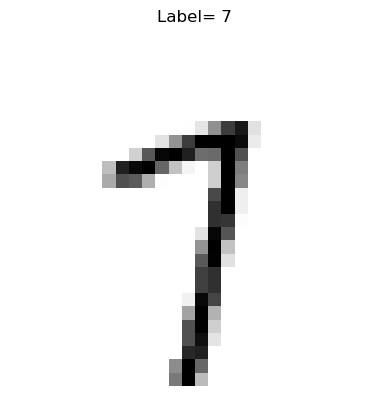

In [27]:
displayDigit(42, X)

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([3056.66366147])

In [29]:
threshold= 0

In [30]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([ True])

Setting a threshold variable as we did above and comparing it to the *decision function* enables us to affirm that 
different thresholds yield different results based on whether we're looking for precision or recall.

In the extreme above with a threshold of 0,  the previous code returnes the same result as the predict method.

Below, with an extreme of 8000, we see recall decreases. In other words, it detects actual 5s with a threshold of 0, but misses them when it's 8000.

In [31]:
threshold= 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([False])

Return decision scores with cross_val_predict to help decide what thresholds to use. 

In [32]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [33]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

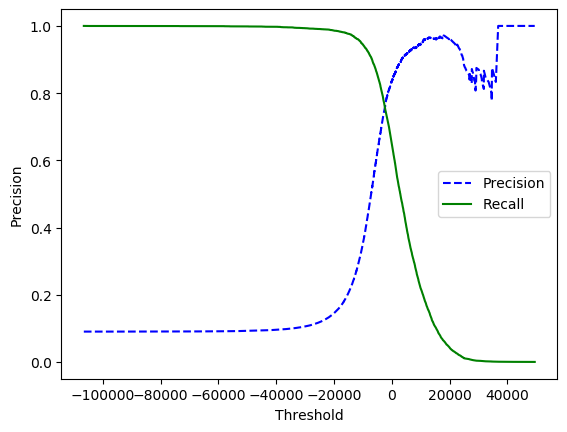

In [34]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    #TODO -add in scale and label code
    plt.xlabel("Threshold")
    plt.ylabel("Precision")
    plt.legend(loc="right")
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [35]:
threshold_90_precision= thresholds[np.argmax(precisions>=0.90)]


In [36]:
y_train_pred_90 = (y_scores>=threshold_90_precision)

# The ROC Curve
The *receiver operating characteristic* curve plots the *true positive rate* (aka recall) against the *false positive rate (FPR)*. It is equal to 1 - the *true negative rate*, also known as *specificity.*

Hence, the ROC curve plots sensitivity verses 1.

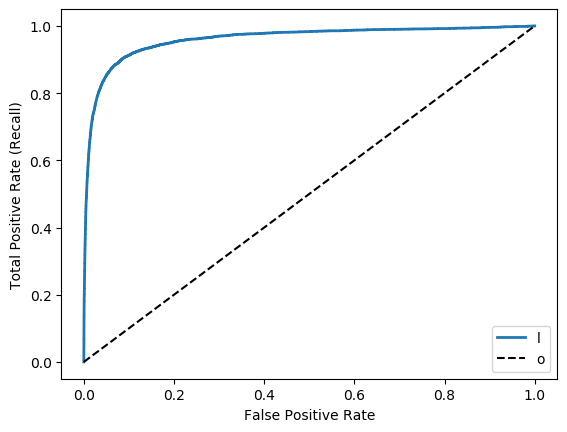

In [37]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr, tpr, linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--') #dashed diagonal
    #todo -- add labels and stuff
    plt.xlabel("False Positive Rate")
    plt.ylabel("Total Positive Rate (Recall)")
    plt.legend("lower right")
    
plot_roc_curve(fpr, tpr, "Random Forest")
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)  

0.9604938554008616

Remember, the higher the recall (TPR), the more false positives the classifier produces. The dotted line represents the ROC curve of a purely random classifier, and a good classifier stays as far from that line as possible. 

To choose between TPR and PR curve, use the PR curve whenever the positive class is rare. 


In [39]:
from sklearn.ensemble import RandomForestClassifier
t0=time.time()
forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")


print("Took: {0:2f} s to fit the full classification.".format(time.time()-t0))

Took: 64.800939 s to fit the full classification.


Receiving Operator Characteristic curves expect labels and scores, but you can also give it class probabilities. 

In [40]:
y_scores_forest= y_probas_forest[:, 1] #score = probability of positive class
fpr_forest, tpr_forest, thresholds_fores = roc_curve(y_train_5, y_scores_forest)

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Time to plot

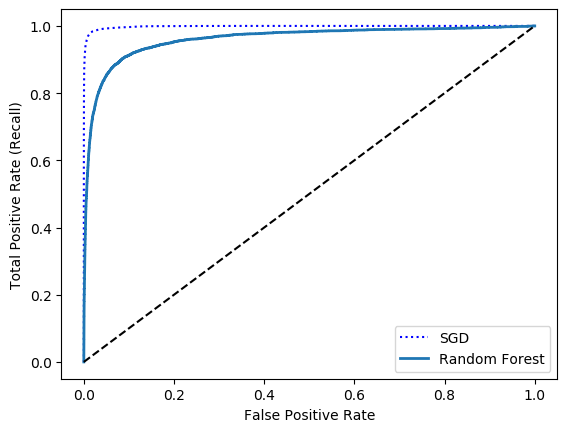

In [42]:
plt.plot(fpr_forest, tpr_forest, "b:", label="SGD")
plot_roc_curve(fpr, tpr, "Random Forest")
plt.legend(loc="lower right")
plt.show()

## ROC Score

In [43]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

As binary classifiers distiguishes between two classes, multiclass classifiers (aka multinominal classifiers) can distiguish between more than two. 

Some alogorithms are natively multiclass (SGD, Random Forest, naive Bayes...).
Some are natively binary (SVM, Logistic Regression...). 

### Strategies for Multiple Binary Classifiers
Known as *One-verse-the-Rest (OVR)* Strategy, one way to create a system that can classify digits is to train 10 binary classifiers for each digit. A 0-detector, 1-detector, etc. 

Then, when you want to get a decision, you slect the class whose classifier puts out the highest score. 

Another is *one-verses-one* Strategy, to train a binary classifer for every pair of digits, one to disiguish between 0s and 1, 0s and 2s, 1 and 2s, etc. That means if there are *N* Classes, you'll need to train *N X (N-1)/2* classifiers. In this case, that'd be *10 x (9)/2 = 45 classifiers*. This could be a real pain for training, especially if the training set is large. 

Some algorithms (such as Support Vector Machines), scale poorly with the size of the training set. OvO can then be preferred as its faster to train many classifiers on a small training set than the other way around. 

Usually though, OVR is preferred.

### Sklearn Automagical OvR/OvO
Scikit-Learn detects when you try to use a binary classification algorithm for a multi-class classification task.

Let's try this with Support Vector Machines. 
Going back to some_digit...


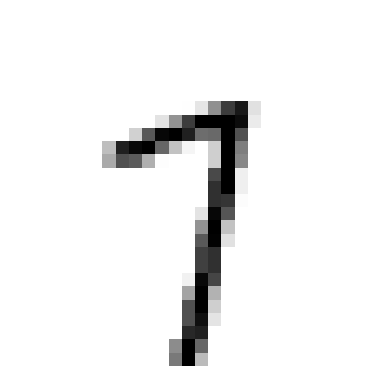

In [44]:
some_digit=X[42]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")

plt.axis("off")
plt.show()

In [45]:
from sklearn.svm import SVC

t0=time.time()
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

print("Took: {0:2f} s to fit the full classification with SVC.".format(time.time()-t0))

Took: 312.875002 s to fit the full classification with SVC.


Under the hood, how did Sklearn actually used a OvO strategy. If you call the *decision_function*, you can see how it scored for each of the 10 classes. 

With **some_digit = 42** for instance, the number seven seems to have won the most duels, followed by the idea of the image being a nine, then the number one.

*np.argmax* essentially shows the same.

In [46]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 0.69755903,  6.25309238,  2.77680055,  5.18242175,  6.85878967,
         2.79256943, -0.30696592,  9.31024051,  2.74850835,  8.30582294]])

In [47]:
np.argmax(some_digit_scores)

7

In [48]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

To force *one-verses-one* or *one-verses-rest*, you can utilize the relative classes within Sklearn.

### One verses Rest

In [49]:
from sklearn.multiclass import OneVsRestClassifier
t0=time.time()

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

ovr_clf.predict([some_digit])

print("Took: {0:2f} s to fit the full classification with One Vs Rest.".format(time.time()-t0))


Took: 1856.276747 s to fit the full classification with One Vs Rest.


~1856.276747 seconds roughly equates to **30 minutes.** Was it worth it? We'll need to score things later to decide.

In [50]:
len(ovr_clf.estimators_)

10

Training a Stotastic Gradiant Descent or one-verses-one classifier is just as straightforward.

### Stotastic Gradiant Descent

In [51]:
from sklearn.linear_model import SGDClassifier
t0=time.time()

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

Took: 114.808710 s to fit the full classification with Stotastic Gradiant Descent.


In [ ]:
elapsed_time = time.time() - t0
minutes, seconds = divmod(elapsed_time, 60)
print("Took: {:.0f} min {0:2f} s to fit the full classification with Stotastic Gradiant Descent.".format(minutes, seconds))

### One verse One

In [52]:
from sklearn.multiclass import OneVsOneClassifier
t0=time.time()

ovo_clf=OneVsOneClassifier(SVC())
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])


Took: 285.646460 s to fit the full classification with One Vs One.


In [ ]:
elapsed_time = time.time() - t0
minutes, seconds = divmod(elapsed_time, 60)
print("Took: {:.0f} min {0:2f} s to fit the full classification with One Vs One.".format(minutes, seconds))

Let's check the scores

In [53]:
ovr_clf.decision_function([some_digit])

array([[-2.51745481, -1.43601605, -1.87062957, -1.41212168, -2.41942856,
        -1.4669391 , -2.71513919,  0.92385246, -2.19836511, -1.00029553]])

In [54]:
sgd_clf.decision_function([some_digit])

array([[-36768.57801841, -14219.37911825, -12155.09285399,
         -7705.55279189, -10826.72986969,  -2155.0792791 ,
        -19761.84104551,   3105.09312651,  -1800.58709659,
          -805.17753406]])

In [55]:
ovo_clf.decision_function([some_digit])

array([[ 0.69719297,  6.25047528,  2.7757069 ,  5.18603734,  6.86452384,
         2.79874432, -0.30686393,  9.31023614,  2.74986306,  8.30570983]])

In [56]:
t0=time.time()
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [ ]:
elapsed_time = time.time() - t0
minutes, seconds = divmod(elapsed_time, 60)
print("Took: {:.0f} min {0:2f} s to score SGD.".format(minutes, seconds))))

In [57]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled= scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

At this point, now that we have models, we'd be seeking to improve it. 

## Confusion Matrix
        Time for confusion matrixes to help us with Error Analysis

In [58]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)


In [59]:
conf_mx=confusion_matrix(y_train, y_train_pred)

In [60]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

For the main diagonal to be bright, that means most things are being predicted correctly. 

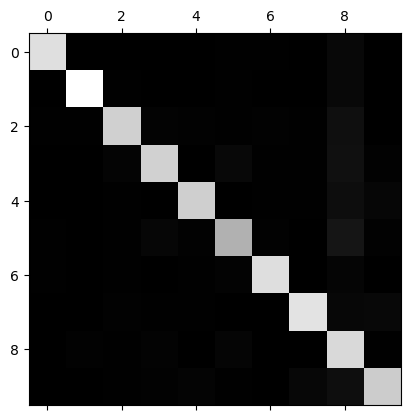

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Now to focus the plot on errors.
Divide the confusion matrix by the number of images in the corresponding classes so we can divide *error rates* instead of the *absolute number* of errors.

In [62]:
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

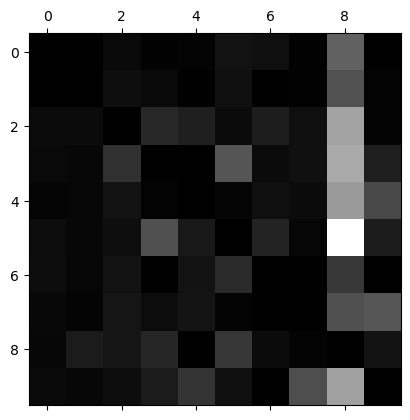

In [63]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Rows means Actual Classes. 
Columns means Predictions.

For the 8 column to be so bright, that means that things get wrongfully predicted and misclassified at an 8. 

So focus on reducing false 8s could be a good idea. The rate on misclassification is often here. Below we'll analyze individual errors.

In [64]:
cl_a, cl_b = 3, 5
##digits classified as 3s
X_aa = X_train[(y_train == cl_a) & (y_train_pred==cl_a)]
##digits classified as 3s
X_ab = X_train[(y_train == cl_a) & (y_train_pred==cl_b)]

#digits classified as 5s
X_ba = X_train[(y_train == cl_b) & (y_train_pred==cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred==cl_b)]

In [65]:
'''
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()
'''

'\nplt.figure(figsize=(8,8))\nplt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)\nplt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)\nplt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)\nplt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)\n\nplt.show()\n'

The left two show digits classified as 3s. The right two blocks show digits classified as 5s. 

This is a demonstration of how a simple classified like SGD might confuse images as it merely assigns a weight per class to each pixel, and when it seees a new image it just sums up the weighted pixel intensities to score each class.

One way to reduce the error is to preprocess the images to ensure they are well centered and not too rotated.

# Multilabel Classification

In [66]:
t0=time.time()
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train>=7)
y_train_odd=(y_train % 2 == 1)
y_multilabel=np.c_[y_train_large, y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
print("Took: {0:2f} s to fit the KNeighbors Classifier.".format(time.time()-t0))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

This multilabel array contains two target labels for each digit. The first checks if its large (7, 8, 9), and the second indicates if the digit is odd. Now you can predict something, and get two booleans statements.

In [67]:
knn_clf.predict([some_digit])

array([[ True,  True]])

There are many ways to evaluate a multilabel classifier. One is the measure the F-Score.

In [72]:
t0=time.time()
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)



Took: 2721.468892 s to Cross Validation Predict for the multilabel classifier.


In [ ]:
elapsed_time = time.time() - t0
minutes, seconds = divmod(elapsed_time, 60)
print("Took: {:.0f} min {0:2f} s to Cross Validation Predict for the multilabel classifier.".format(minutes, seconds))

The above assums all labels are equally imporant (which may or may not be the case). That's why we give each label a weight equal to it's *support* (number of instances with that target label). To do this, simply set average="weighted" in the preceding code.

In [73]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605